In [46]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166691 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
pdf = adata.copy()

data = [
    'pellin',
    'iHSC',
    'young2_HSC',
    'tabula_sapiens',
]

mask = pdf.obs['dataset'].isin(data)
pdf = pdf[mask, :]

# drop HSC from tabula
mask = (pdf.obs['celltype'] == 'HSC') & (pdf.obs['dataset'] == 'tabula_sapiens')
pdf = pdf[~mask, :]

# # drop lin- cells from pellin
# mask = (pdf.obs['cell_type'].str.contains('LinNeg')) & (pdf.obs['dataset'] == 'pellin')
# pdf = pdf[~mask, :]


keep_cols = [
    'n_genes',
    'cell_type',
    'dataset',
    'organ_tissue',
    'compartment',
]

pdf.obs = pdf.obs[keep_cols]

sc.pp.filter_genes(pdf, min_counts=3)
sc.pp.filter_cells(pdf, min_counts=100)

sc.pp.normalize_total(pdf)
sc.pp.log1p(pdf)

sc.pp.combat(pdf, key='dataset')

# handle negatives
pdf.X = np.where(pdf.X < 0, 0, pdf.X)

sc.pp.highly_variable_genes(pdf)


pdf

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 60263 × 19114
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [4]:
pdf.obs['dataset'].value_counts()

dataset
tabula_sapiens    26586
pellin            21412
iHSC               8562
young2_HSC         3703
Name: count, dtype: int64

In [5]:
pdf.obs['cell_type'].value_counts()

cell_type
FB                        26586
iHSC                       8562
LinNegCD34PosCD164Pos      6343
HSC                        4525
LinNegCD34NegCD164high     4434
LinNegCD34lowCD164high     4266
CMP                        1576
MEP                        1211
GMP                        1012
MPP                         611
PreBNK                      592
LinNegCD34NegCD164low       358
MLP                         123
MKP                          64
Name: count, dtype: int64

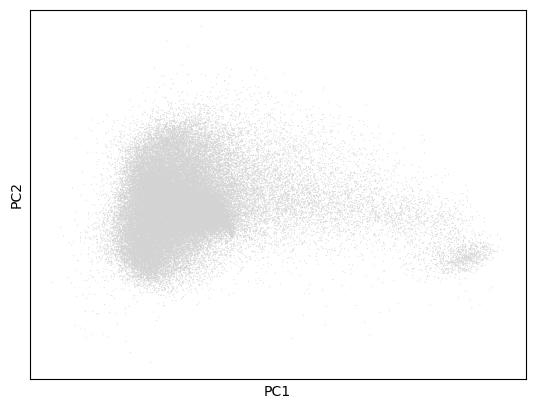

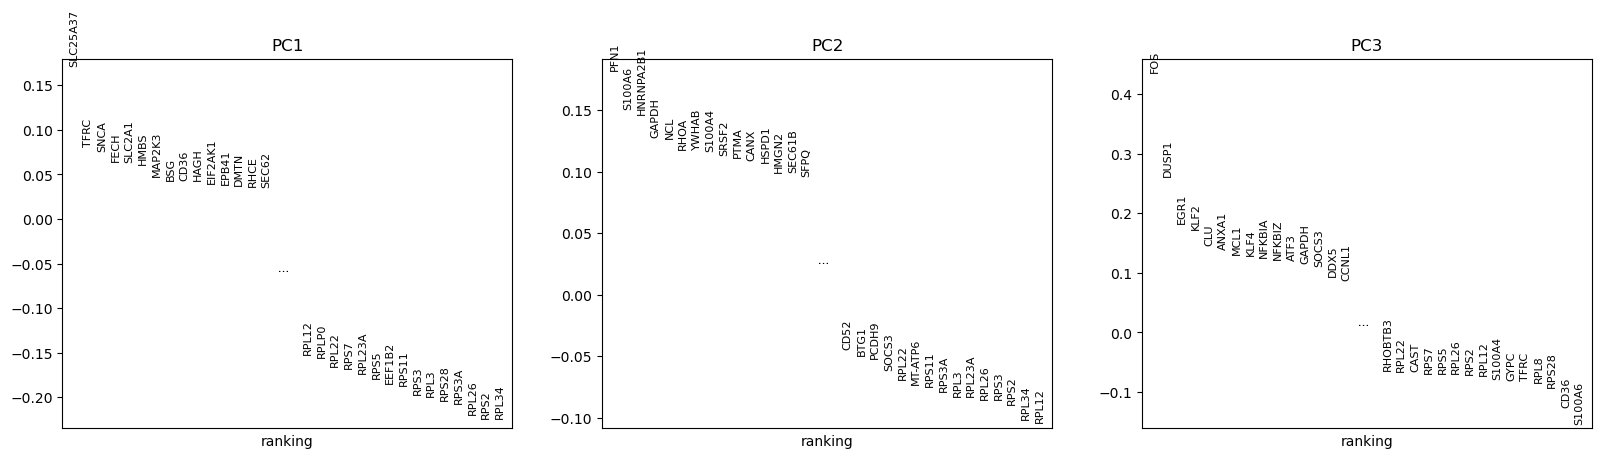

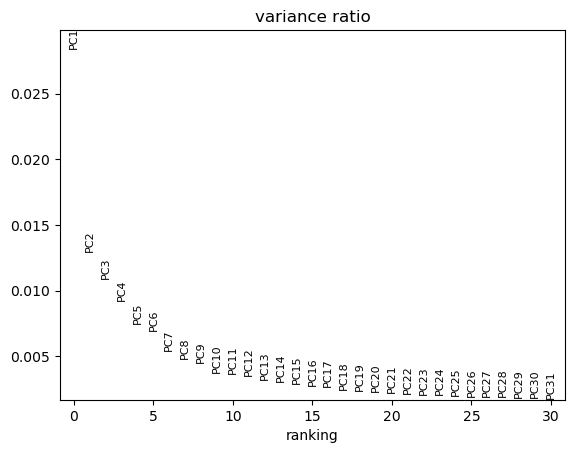

done


In [6]:
sc.tl.pca(pdf, svd_solver="arpack")
sc.pp.neighbors(pdf)
sc.tl.umap(pdf)

sc.pl.pca_overview(pdf)

print('done')

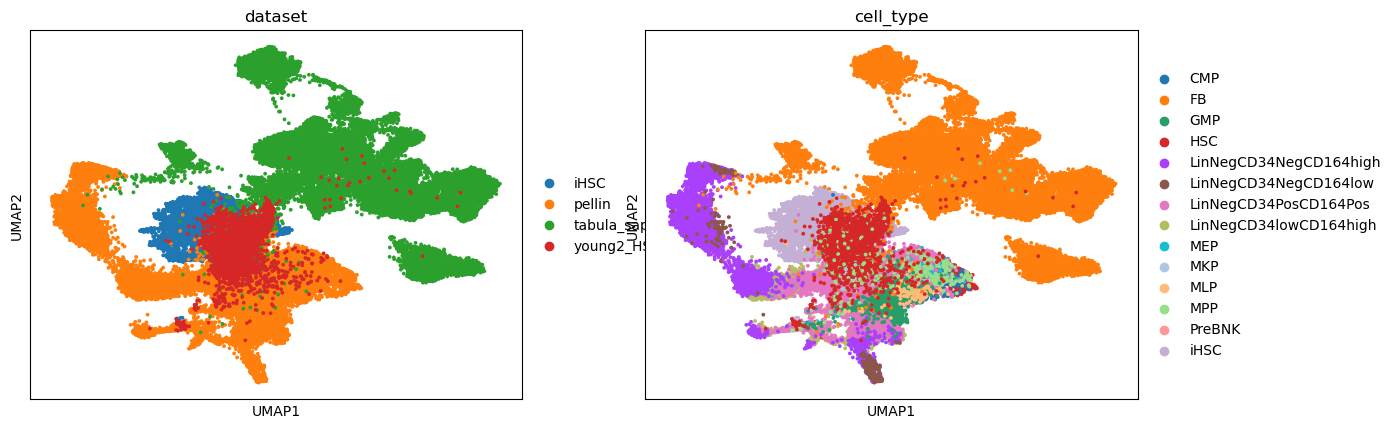

In [7]:
sc.pl.umap(pdf, 
           color=['dataset','cell_type'],
           s=30,)

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

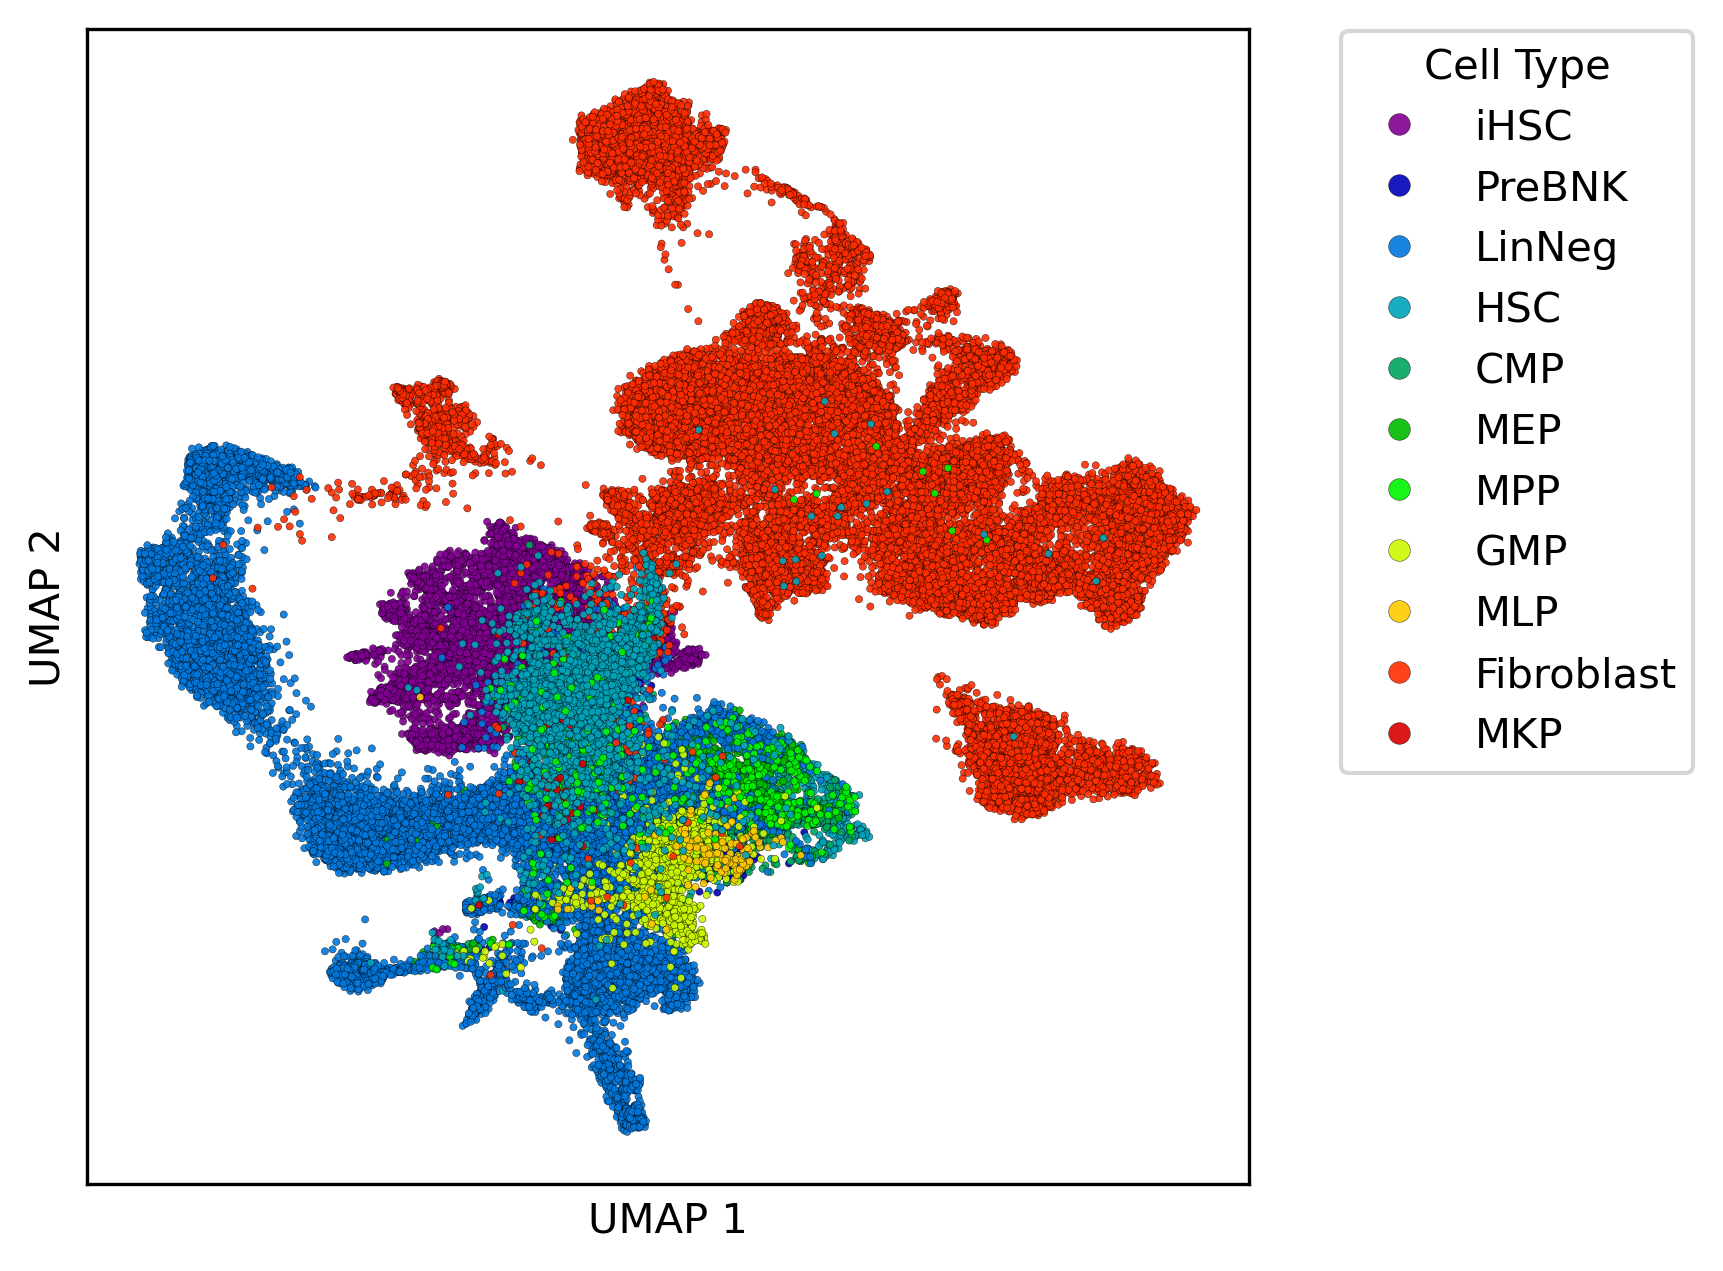

In [25]:
pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

cell_map = {
    'iHSC' : 'iHSC',
    'PreBNK' : 'PreBNK',
    'LinNegCD34lowCD164high' : 'LinNeg',
    'HSC' : 'HSC',
    'CMP' : 'CMP',
    'MEP' : 'MEP',
    'LinNegCD34PosCD164Pos' : 'LinNeg',
    'LinNegCD34NegCD164high' : 'LinNeg',
    'MPP' : "MPP",
    'GMP' : "GMP",
    'LinNegCD34NegCD164low' : 'LinNeg',
    'MLP' : "MLP",
    'FB' : "Fibroblast",
    'MKP' : "MKP"
}

pdf.obs['broad_type'] = pdf.obs['cell_type'].map(cell_map)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=pdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                lw=0.1,
                alpha=0.9,
                hue='broad_type',
                palette="nipy_spectral",
                s=3)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Cell Type",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.4, 1.017))

plt.gca().set_aspect('auto')

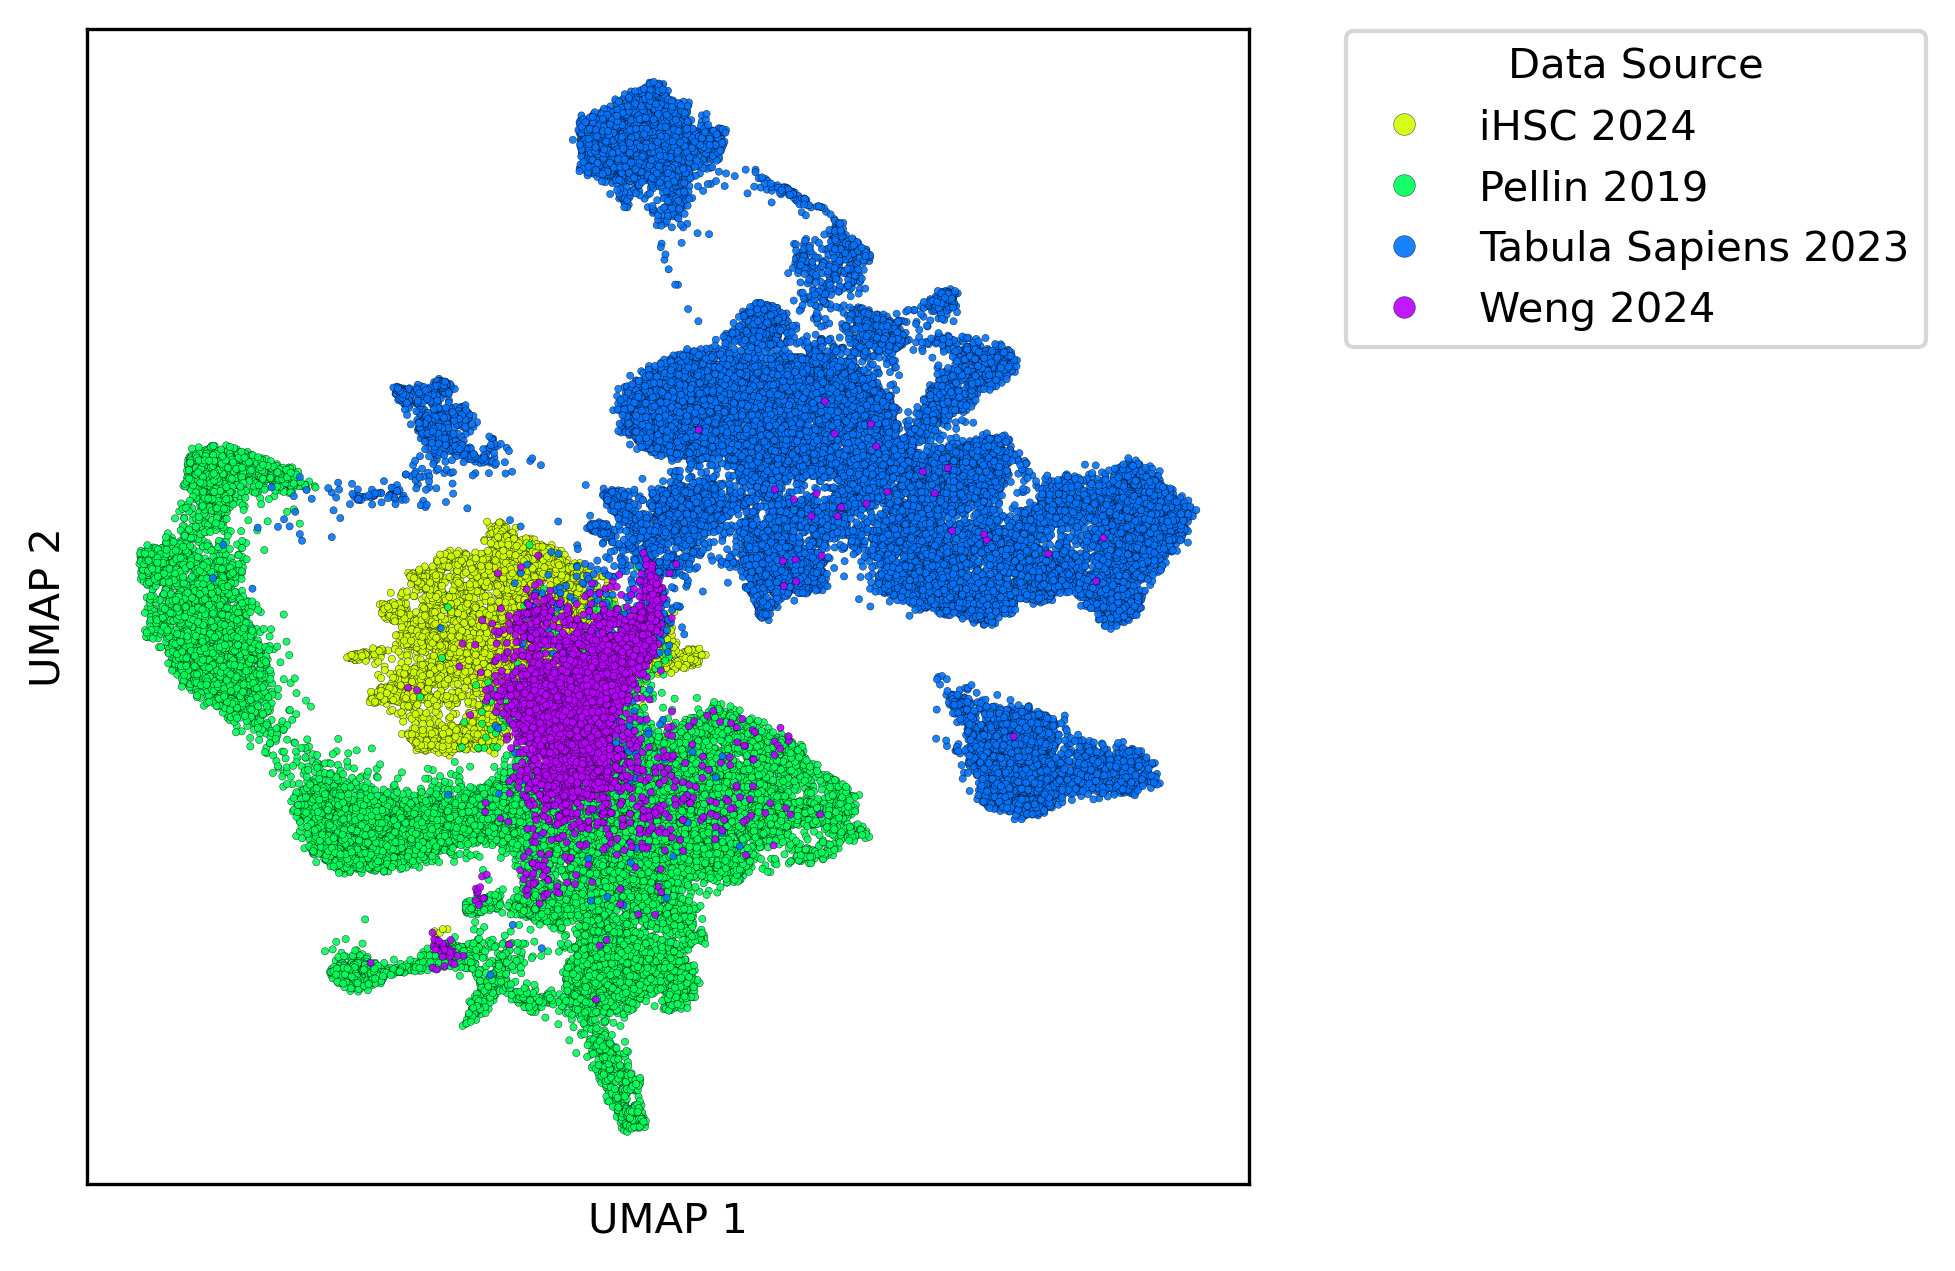

In [30]:

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

data_map = {
    'iHSC' : 'iHSC 2024', 
    'pellin' : 'Pellin 2019', 
    'tabula_sapiens' : 'Tabula Sapiens 2023',
    'young2_HSC' : 'Weng 2024',
}

pdf.obs['Data Source'] = pdf.obs['dataset'].map(data_map)

sns.scatterplot(data=pdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                lw=0.1,
                alpha=0.9,
                hue='Data Source',
                palette="hsv",
                s=3)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Data Source",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.6, 1.017))

plt.gca().set_aspect('auto')

In [ ]:
break

# PAGA

In [ ]:
# sc.tl.paga(pdf, groups="cell_type")
# sc.pl.paga(pdf)
# sc.pp.neighbors(pdf)
# sc.tl.umap(pdf, init_pos='paga')

# sc.pl.umap(pdf, color='cell_type')

In [ ]:
# pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
# pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

# plt.rcParams['figure.dpi'] = 300

# sns.scatterplot(data=pdf.obs,
#                 x='UMAP 1',
#                 y='UMAP 2',
#                 ec='k',
#                 lw=0.1,
#                 alpha=0.9,
#                 hue='broad_type',
#                 palette="nipy_spectral_r",
#                 s=3)


# plt.xticks([])
# plt.yticks([])
# sns.despine()

# sns.move_legend(plt.gca(), 
#                 title="Cell Type",
#                 loc='upper right',
#                 markerscale=3,
#                 bbox_to_anchor=(1.6, 1))
# plt.gca().set_aspect('equal')

In [ ]:
# break

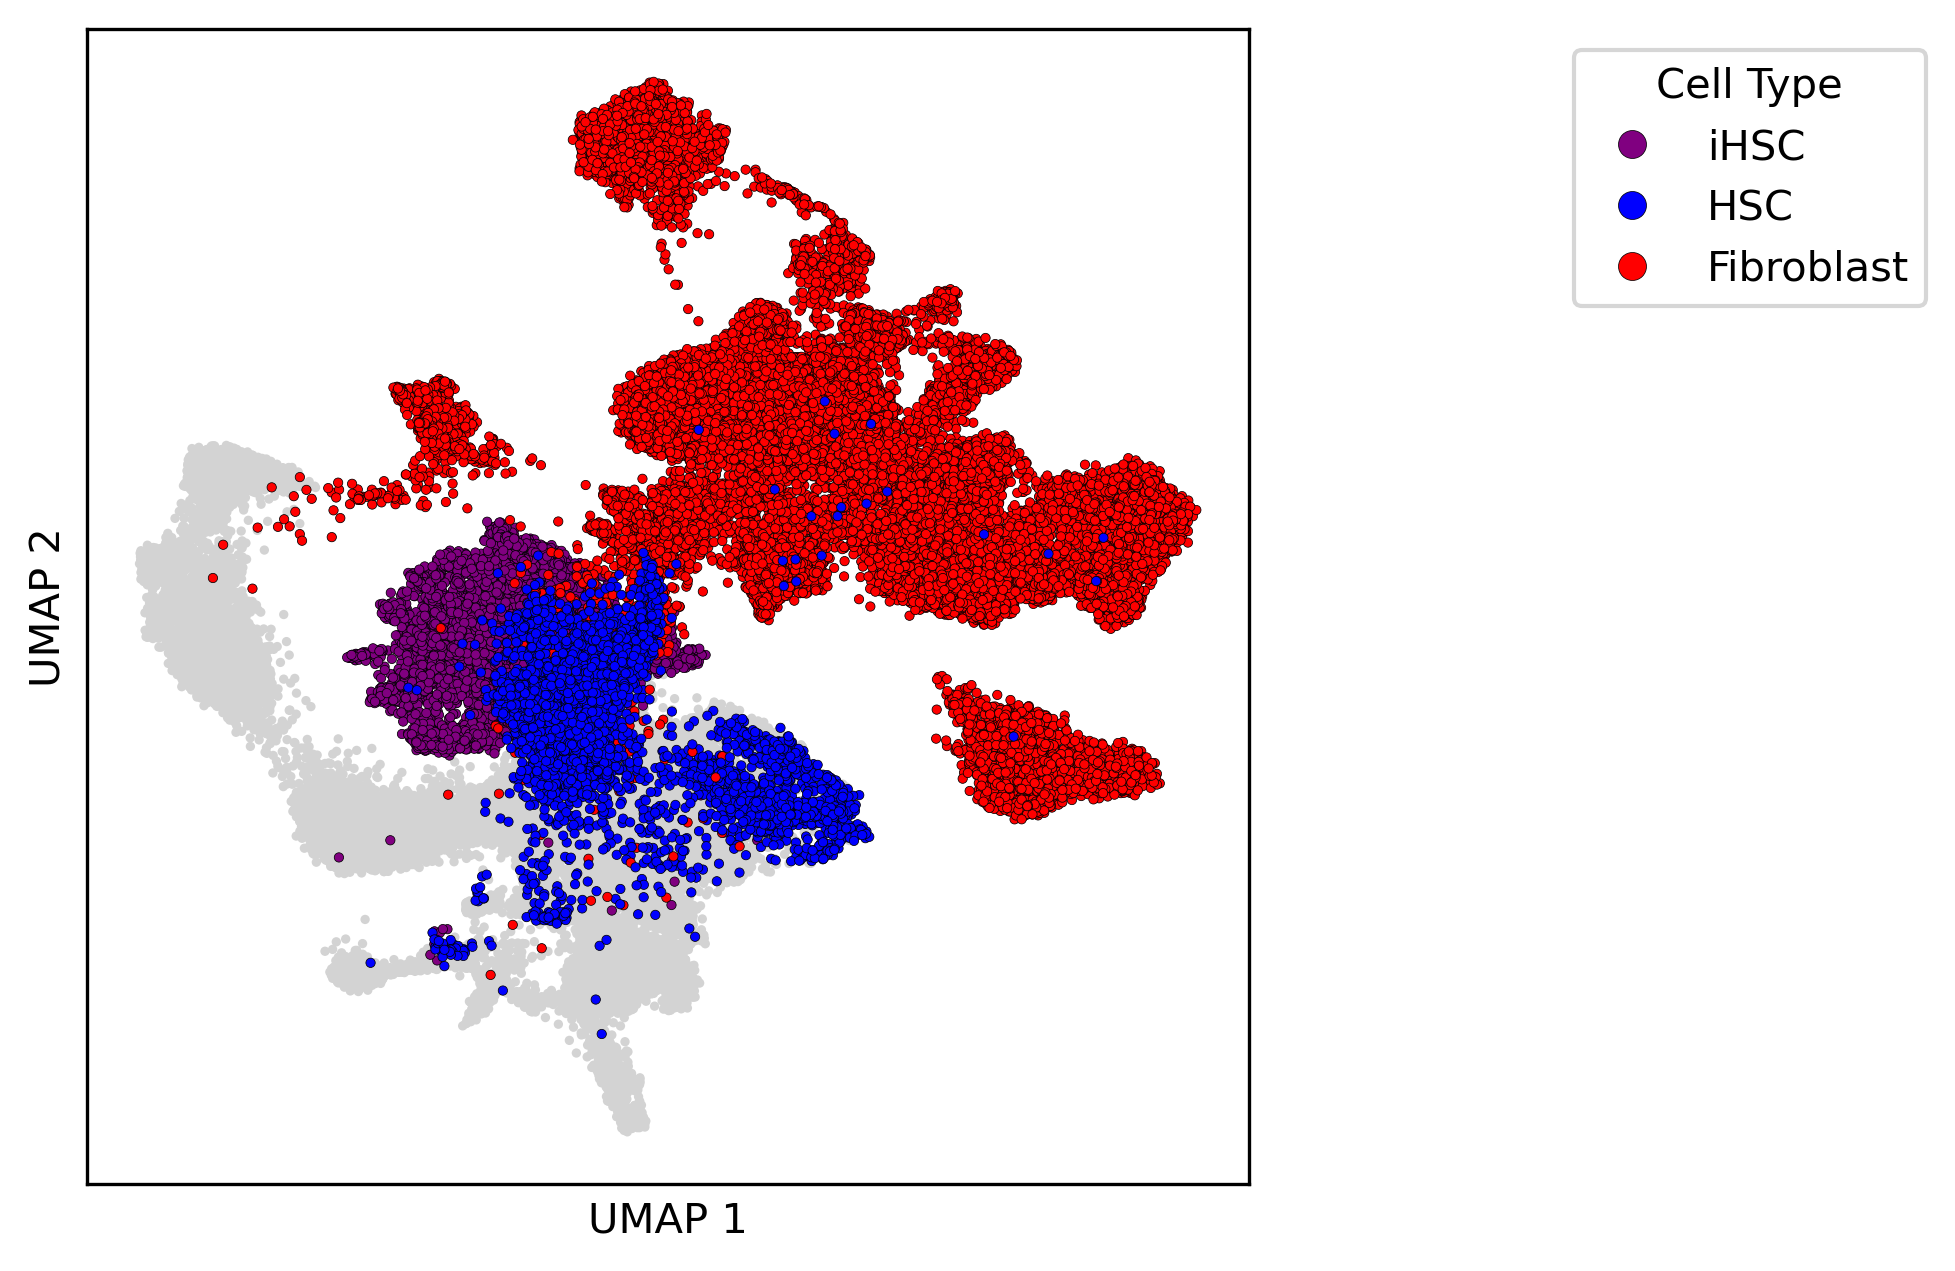

In [33]:
pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=pdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='None',
                zorder=0,
                color='lightgrey',
                s=5)


mask = pdf.obs['cell_type'].isin(["HSC", "iHSC", 'FB'])
to_plot = pdf.obs[mask].reset_index(drop=False).copy()
to_plot['cell_type'] = to_plot['cell_type'].astype(str)

sns.scatterplot(data=to_plot,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                zorder=2,
                hue='broad_type',
                palette=['purple', "blue", "red"],
                s=5)

plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Cell Type",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.6, 1))

plt.gca().set_aspect('auto')

In [ ]:
# to_plot['cell_type'].value_counts()

# Distance in UMAP space

In [ ]:
# def min_max(v):
#     return (v - v.min()) / (v.max() - v.min())

# metric = 'euclidean'

# our = pdf.obs[pdf.obs['broad_type'] == 'iHSC'].copy()

# columns = ['UMAP 1', 'UMAP 2']
# X = our[columns].to_numpy()

# medians = to_plot.groupby('broad_type').agg(
#     UMAP1 = ('UMAP 1', 'median'),
#     UMAP2 = ('UMAP 2', 'median'),
# ).reset_index()

# medians


# cell_types = []
# # 
# for idx, row in medians.iterrows():
#     cell_types.append(row['broad_type'])
#     Y = row[['UMAP1', 'UMAP2']].to_numpy().reshape(1, -1)
#     d = sklearn.metrics.pairwise_distances(X, Y, metric=scipy.spatial.distance.euclidean)
#     our[row['broad_type']] = np.ravel(d)


# our.head()

In [ ]:
# our['score'] = our['Fibroblast'] - our['HSC']

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 2
# sns.histplot(data=our,
#              x='score')

# plt.axvline(x=0, lw=1, ls=":", c='r')

# plt.ylabel('n Cells')
# plt.xlabel(r'$d_{fib} - d_{hsc}$')
# plt.xticks([])
# sns.despine()

In [ ]:


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 5, 5

# sns.scatterplot(data=pdf.obs,
#                 x='UMAP 1',
#                 y='UMAP 2',
#                 ec='None',
#                 zorder=0,
#                 color='lightgrey',
#                 s=5)


# sns.scatterplot(data=our,
#                 x='UMAP 1',
#                 y='UMAP 2',
#                 ec='k',
#                 zorder=2,
#                 hue='score',
#                 palette='coolwarm_r',
#                 s=5)

# plt.xticks([])
# plt.yticks([])
# sns.despine()
# plt.gca().set_aspect('equal')


# sns.move_legend(plt.gca(), 
#                 title="Cell Type",
#                 loc='upper right',
#                 markerscale=3,
#                 bbox_to_anchor=(1.6, 1))

In [ ]:
# plot = our.copy().reset_index()
# plot = pd.melt(plot, id_vars='index',
#                value_vars=cell_types)

# include = [
#     'Fibroblast',
#     'HSC',
# ]

# mask = plot['variable'].isin(include)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 5, 3
# sns.histplot(data=plot[mask],
#              x='value',
#              hue='variable',
#              kde=True)

# plt.xlabel(f"{metric.title()} Distance")

# sns.move_legend(plt.gca(), 
#                 title="Distance to:",
#                 loc='best')

# sns.despine()

In [ ]:
# plot = our.copy().reset_index()

# sns.scatterplot(data=our,
#                 x='HSC',
#                 y='Fibroblast')

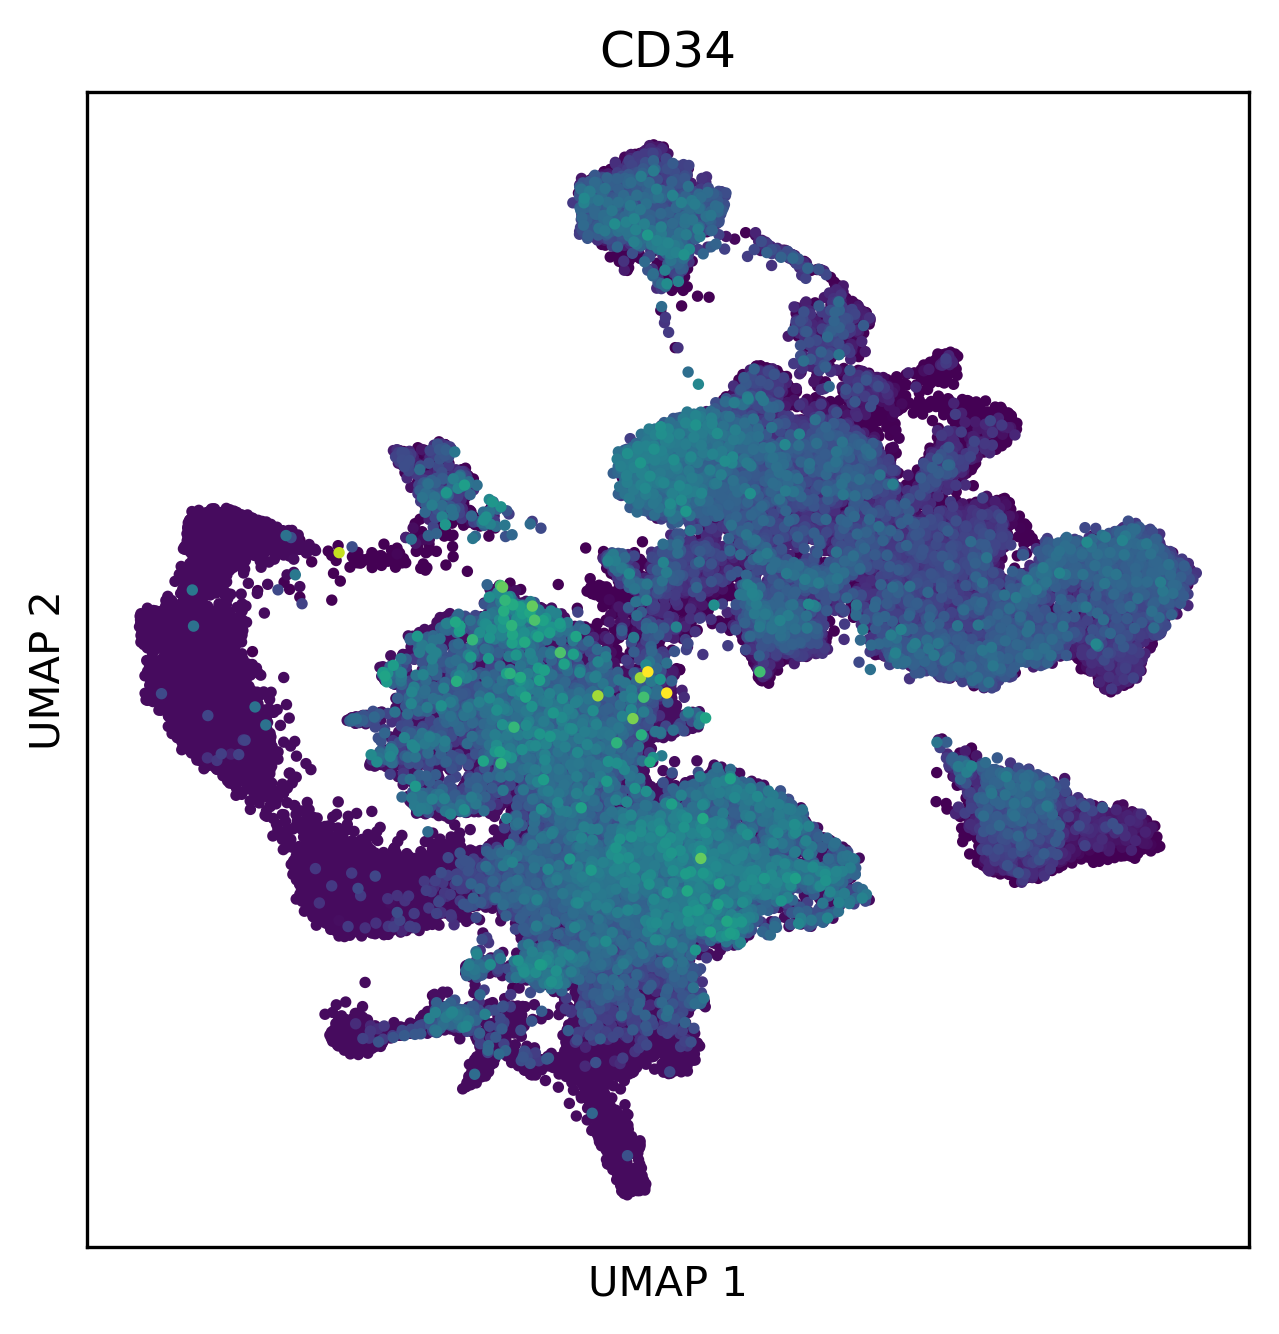

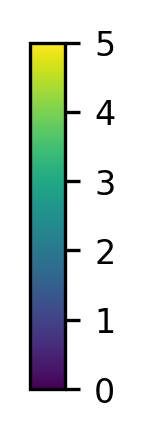

In [51]:
def scatter_colorbar(scatter_result):
    """Creates a standalone colorbar figure from a matplotlib scatter plot result.

    Args:
        scatter_result: The return value of plt.scatter().

    Returns:
        A matplotlib figure object containing the colorbar.
    """

    # Extract color data and normalization
    cmap = scatter_result.cmap
    norm = scatter_result.norm
    if isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap)

    # Create a new figure and axes for the colorbar
    fig, ax = plt.subplots(figsize=(0.15, 1.5))  # Adjust figsize for height

    # Use a ScalarMappable to create the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar data

    # Add the colorbar to the figure
    cbar = plt.colorbar(sm, cax=ax)
    cbar.ax.tick_params(labelsize=8)  # Adjust label size as needed

    return fig


def plot_umap_scatter(
    adata, x= "UMAP 1", 
    y="UMAP 2", color="CD34", 
    cmap="viridis",
    vmin=None,
    vmax=None,
    **kwargs
) -> plt.Axes:
    """
    Creates a scatterplot of UMAP data from an AnnData object with color mapping and a colorbar.

    Args:
        adata (anndata.AnnData): The AnnData object containing the UMAP embedding and color data.
        x (str, optional): Column name in `adata.obsm` for x-coordinates (default: "UMAP 1").
        y (str, optional): Column name in `adata.obsm` for y-coordinates (default: "UMAP 2").
        color (str, optional): Column name in `adata.var` or `adata.obs` for color mapping (default: "CD34").
        cmap (str or matplotlib.colors.Colormap, optional): Colormap to use (default: "viridis").
        vmin (float, optional): Minimum value for colormap normalization (default: None).
        vmax (float, optional): Maximum value for colormap normalization (default: None).
        **kwargs: Additional keyword arguments passed to `plt.scatter`.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.

    Raises:
        KeyError: If `color` is not found in `adata.var` or `adata.obs`.
    """

    if color in adata.var_names:  # Color is a gene expression value
        df = adata.to_df()
        df.columns = adata.var['gene_name'].values  # Use gene names as column labels
        expression = df[color].values  
    elif color in adata.obs:
        expression = adata.obs[color].values
    else:
        raise KeyError(f"Color key '{color}' not found in adata.var or adata.obs")

    # Sort points for smooth colorbar
    order = np.argsort(expression)

    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(expression)
    if vmax is None:
        vmax = np.max(expression)

    # Create scatterplot with normalized colormap
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        adata.obs[x].iloc[order],
        adata.obs[y].iloc[order],
        c=expression[order],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        **kwargs
    )
    
    ax.set_aspect('auto')

    # Additional formatting
    ax.set(
        title=color,
        xlabel=x,
        ylabel=y,
        xticks=[],
        yticks=[]
    )
    
    scatter_colorbar(scatter)
    


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, vmin=0, vmax=5, s=3)


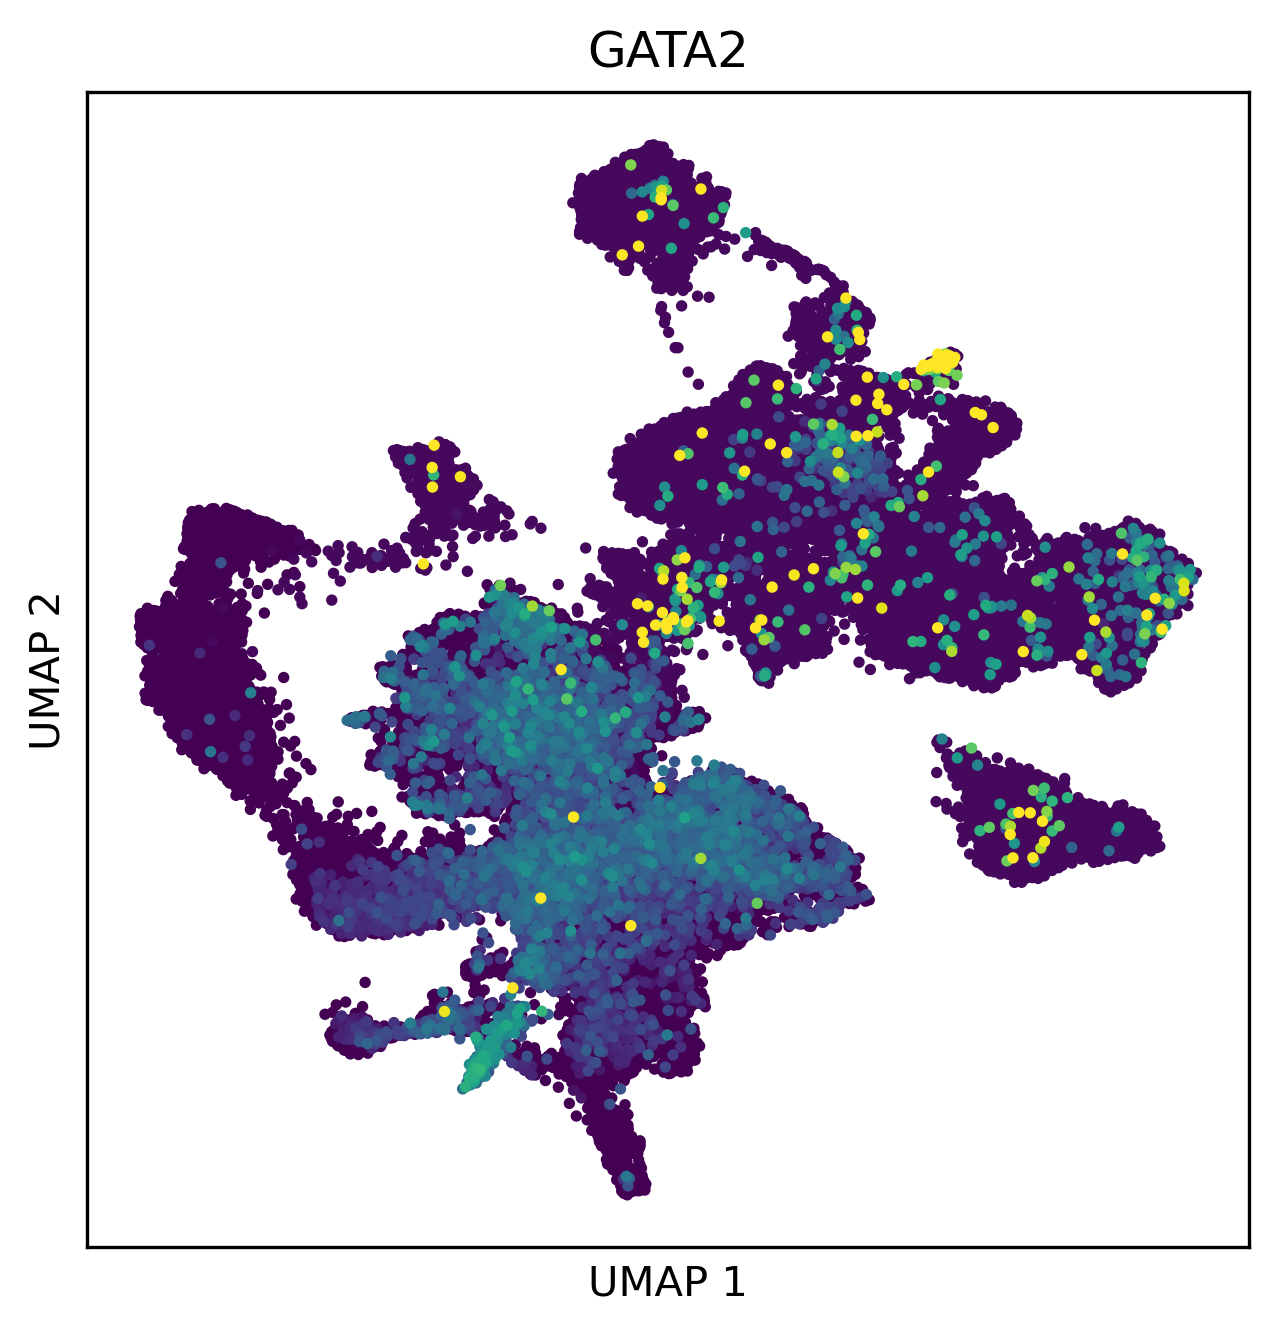

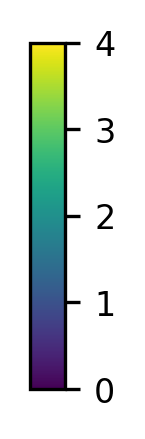

In [52]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='GATA2', vmin=0, vmax=4, s=3)

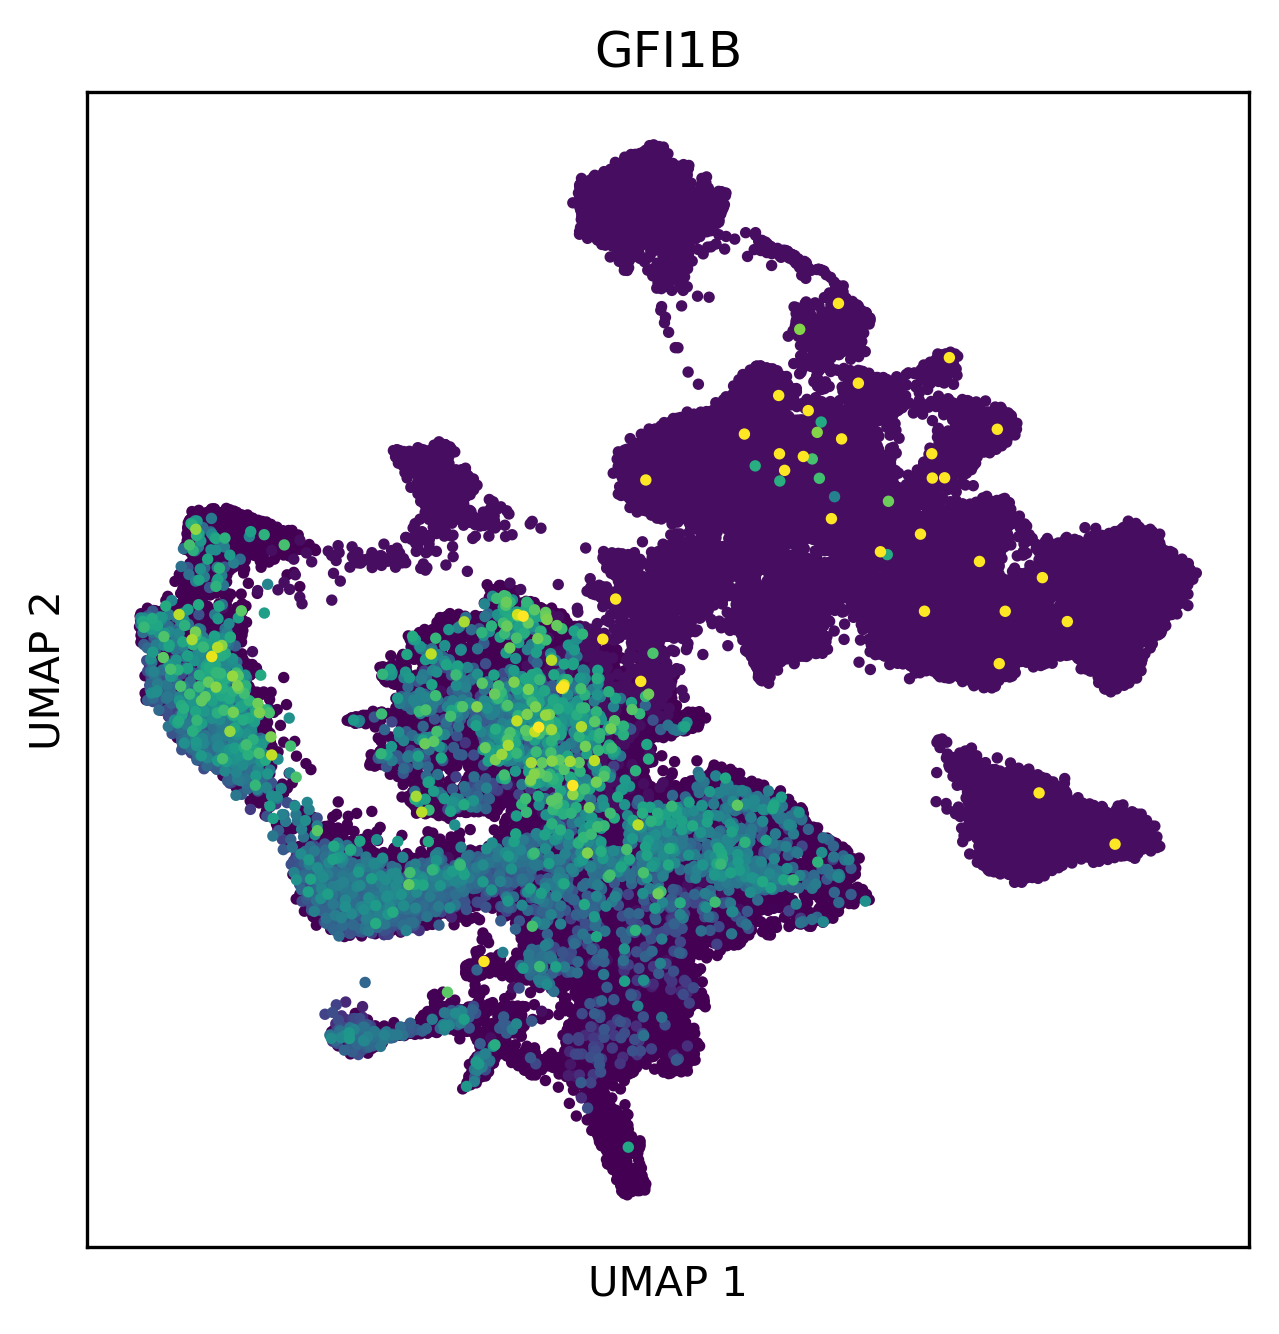

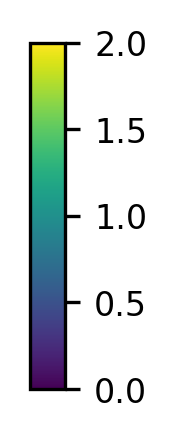

In [53]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='GFI1B', vmin=0, vmax=2, s=3)

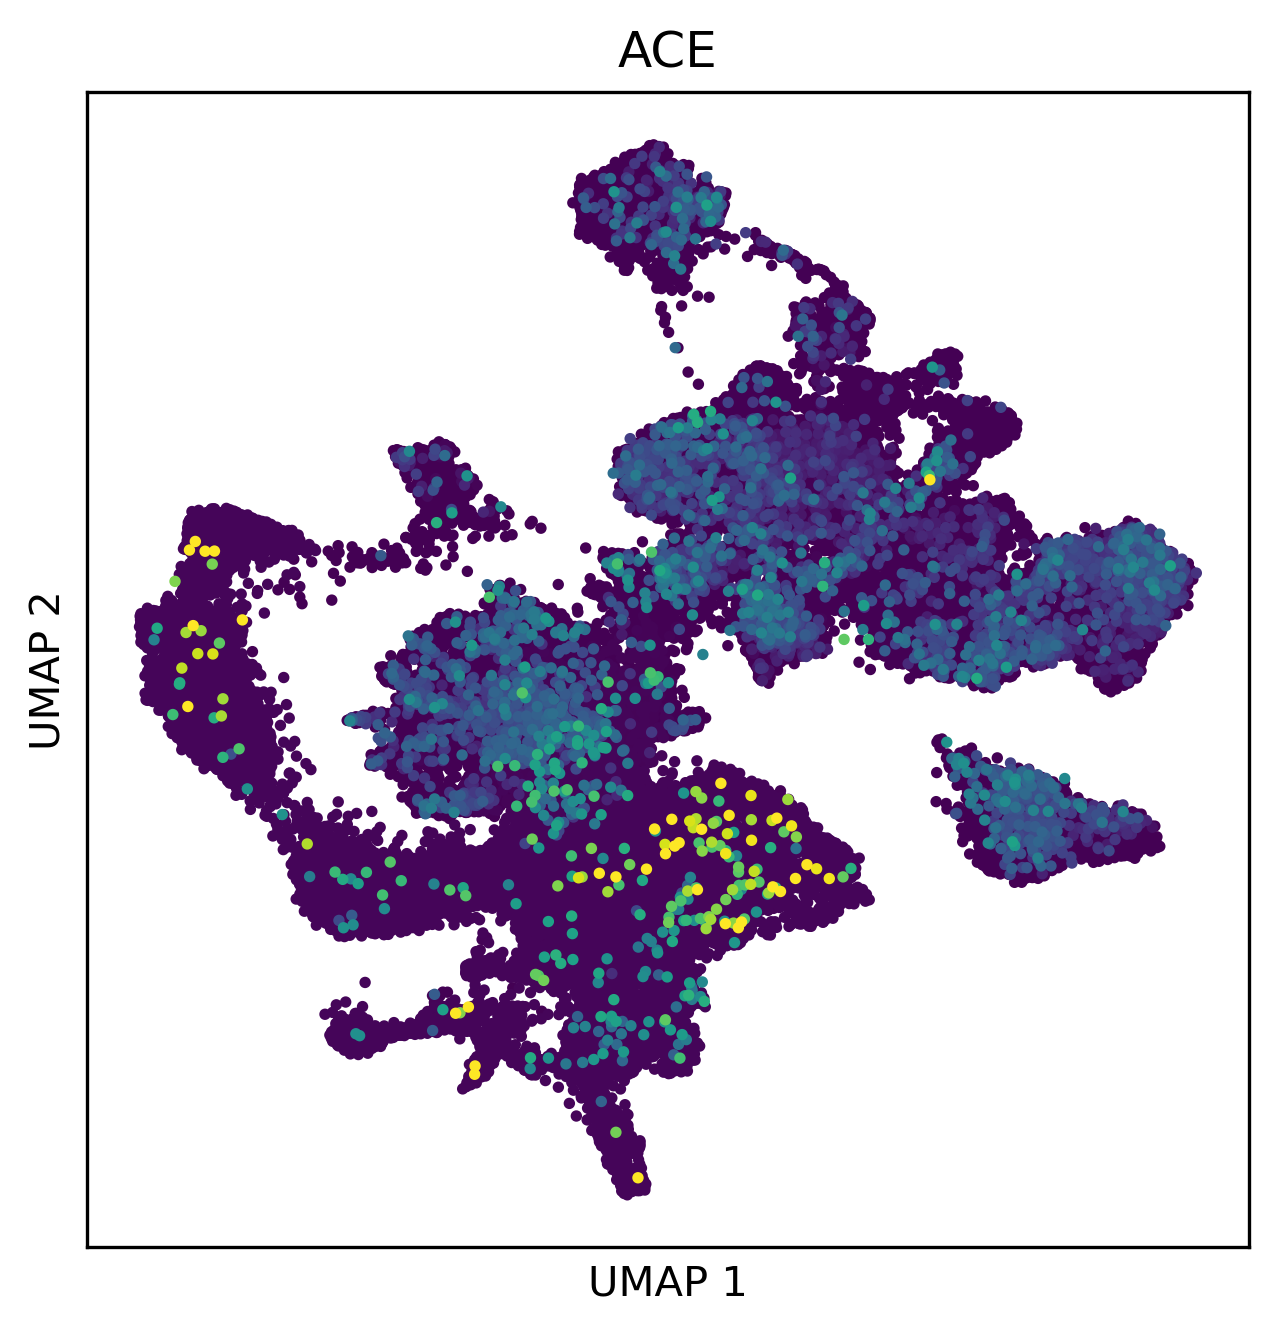

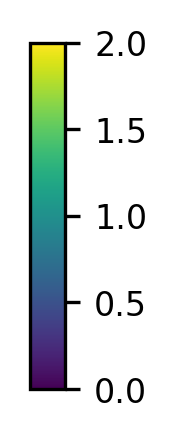

In [54]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='ACE', vmin=0, vmax=2, s=3)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='MGST1', s=3)

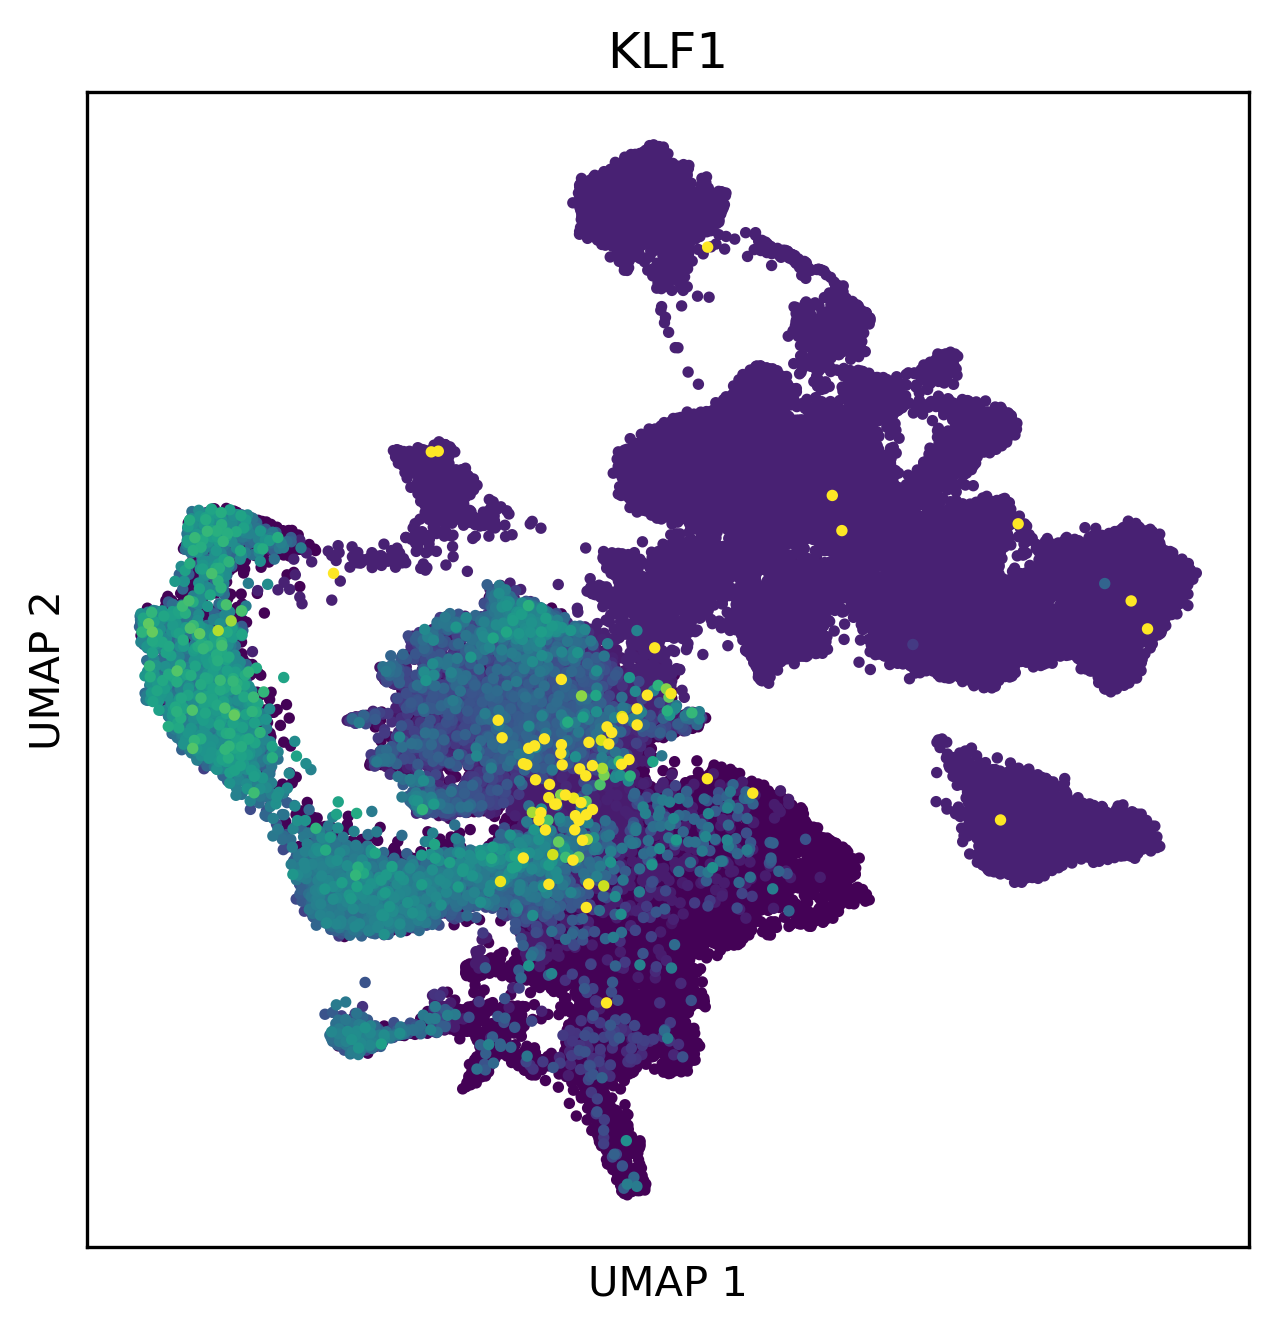

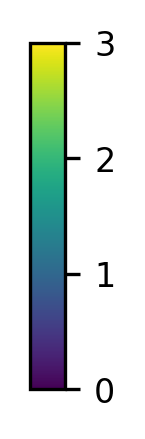

In [55]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='KLF1', vmin=0, vmax=3, s=3)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plot_umap_scatter(pdf, color='ALDH1A1', vmin=0, vmax=3, s=3)

# DISTANCE

In [ ]:
iHSC = pdf[pdf.obs['broad_type'] == 'iHSC', :]
HSC = pdf[pdf.obs['broad_type'] == 'HSC', :]
FB = pdf[pdf.obs['broad_type'] == 'Fibroblast', :]

print(f"{iHSC.obsm['X_pca'].shape=} {HSC.obsm['X_pca'].shape=} {FB.obsm['X_pca'].shape=}")

In [ ]:
metric = 'euclidean'

D2FB = scipy.spatial.distance.cdist(iHSC.obsm['X_pca'], 
                                    FB.obsm['X_pca'], 
                                    metric=metric
                                   )

D2HSC = scipy.spatial.distance.cdist(iHSC.obsm['X_pca'],
                                     HSC.obsm['X_pca'], 
                                     metric=metric
                                    )

print(f"{D2FB.shape=}")
print(f"{D2HSC.shape=}")

dist = pd.DataFrame({
    'distance_2_fb' :  D2FB.mean(axis=1),
    'distance_2_hsc' : D2HSC.mean(axis=1),
})


dist.index = iHSC.obs.index

dist.head()

In [ ]:
def calculate_relative_position(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculates the relative position of values in two vectors on a scale of -1 to 1.

    Args:
        x: A numpy array with values between 0 and -n.
        y: A numpy array with values between 0 and m.

    Returns:
        A numpy array of relative positions between -1 and 1.
    """

    # Ensure vectors are of the same length
    if len(x) != len(y):
        raise ValueError("Input vectors must have the same length.")

    # Normalize x and y to the range [-1, 1]
    x_normalized = x / abs(x.min())  
    y_normalized = y / y.max()

    # Calculate relative positions
    relative_positions = (x_normalized + y_normalized) / 2

    return relative_positions

def continuum(df: pd.DataFrame, dist_col1: str, dist_col2: str, decay_factor: float = 1.0) -> pd.Series:
    """Plots cells along a continuum based on exponential decay of two distance columns.

    Args:
        df: A DataFrame containing the distance columns.
        dist_col1: The name of the first distance column.
        dist_col2: The name of the second distance column.
        decay_factor: The factor controlling the exponential decay rate.

    Returns:
        A Series with the cell_id as index and the continuum position as values.
    """
    # Exponential decay calculation
    x = np.exp(-decay_factor * df[dist_col1])
    y = np.exp(-decay_factor * df[dist_col2])

    # Calculate continuum positions
    continuum_positions = calculate_relative_position(x, y)
    continuum_positions = pd.Series(continuum_positions, index=df.index)
    return continuum_positions.sort_values()
    
    
cont = continuum(dist, 
                 dist_col1='distance_2_fb', 
                 dist_col2='distance_2_hsc')   

cont.max()
# sns.histplot(cont)

In [ ]:
break

In [ ]:
dist.columns

# Plot the basins

In [ ]:
def plot_basin(df, x='UMAP 1', y='UMAP 2', cmap="Reds", bins=100, pthresh=.1, levels=4):
    """
    Plots a basin based on UMAP dimensionality reduction, combining scatter, 2D histogram, and density contours with automatic color selection.

    Args:
        df (pandas.DataFrame): The dataframe containing the UMAP coordinates.
        x (str): The column name for the x-axis ('UMAP 1' by default).
        y (str): The column name for the y-axis ('UMAP 2' by default).
        cmap (str): The colormap for the 2D histogram ("Reds" by default).
        bins (int): The number of bins for the 2D histogram (100 by default).
        pthresh (float): The percentile threshold for the 2D histogram (0.1 by default).
        levels (int): The number of contour levels for the density plot (4 by default).
    """

    # 2D Histogram: Shows density distribution
    sns.histplot(data=df, x=x, y=y, bins=bins, pthresh=pthresh, cmap=cmap)

    # Determine Color for Contours based on colormap
    cmap_obj = plt.cm.get_cmap(cmap)  # Get the colormap object
    contour_color = cmap_obj(0.8)  # Choose a color towards the end of the colormap
    
    # 3. Density Contours: Smoothly outlines areas of high density
    sns.kdeplot(data=df, x=x, y=y, levels=levels, color=contour_color, linewidths=0.5)
    
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7
plot_basin(HSC.obs, cmap='Greens')
plot_basin(FB.obs, cmap='Blues')
sns.scatterplot(data=iHSC.obs, 
               x='UMAP 1',
               y='UMAP 2',
               c='r',
               ec='none',
               s=0.25,
               )
plt.xticks([])
plt.yticks([])

In [ ]:
def plot_density_basin(df, x='UMAP 1', y='UMAP 2', cmap="Reds", bins=500, pthresh=.1, alpha_max=0.8):
    """
    Plots a basin based on UMAP dimensionality reduction, combining scatter, 2D histogram, and fading density representation.

    Args:
        df (pandas.DataFrame): The dataframe containing the UMAP coordinates.
        x (str): The column name for the x-axis ('UMAP 1' by default).
        y (str): The column name for the y-axis ('UMAP 2' by default).
        cmap (str): The colormap for the 2D histogram ("Reds" by default).
        bins (int): The number of bins for the 2D histogram (100 by default).
        pthresh (float): The percentile threshold for the 2D histogram (0.1 by default).
        alpha_max (float): The maximum alpha value for the density plot (0.8 by default).
    """
    #Calculate density
    x_values = df[x]
    y_values = df[y]
    xx, yy = np.mgrid[x_values.min():x_values.max():100j, y_values.min():y_values.max():100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_values, y_values])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # 2D Histogram: Shows density distribution
    sns.histplot(data=df, x=x, y=y, bins=bins, pthresh=pthresh, cmap=cmap)

    # Fading Density Representation:
    plt.imshow(np.rot90(f), 
               cmap=cmap, 
               alpha=alpha_max, 
               extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
    
    
plot_density_basin(HSC.obs)
plot_density_basin(FB.obs, cmap='Blues')

In [ ]:
break

# Pseudotime

In [ ]:
mask = (pdf.obs['cell_type'] != 'FB')
hdf = pdf[mask, :].copy()

sc.pp.combat(hdf, key='dataset')

# handle negatives
hdf.X = np.where(hdf.X < 0, 0, hdf.X)

# reprocess
sc.pp.highly_variable_genes(hdf, n_top_genes=2000)

sc.tl.pca(hdf)
sc.pp.neighbors(hdf)
sc.tl.umap(hdf) 

hdf

In [ ]:
sc.pl.umap(hdf,
           color=['cell_type', 'dataset'],
           s=50)

In [ ]:
root_type = "HSC"
hdf.uns['iroot'] = np.flatnonzero(hdf.obs['cell_type'] == root_type)[0]

sc.tl.diffmap(hdf, n_comps=21)
sc.pp.neighbors(hdf, n_neighbors=7)
sc.tl.dpt(hdf, n_branchings=0)

hdf

In [ ]:
sc.pl.umap(hdf,
           color='dpt_pseudotime',
           vmin=0, 
           vmax=0.5,
           s=50)

In [ ]:
break

In [ ]:
break